# backstress model solution

In [1]:
from deformation_models.backstress_model import ModelContainer, sigmadot_p, epsdot_p
from unyt import unyt_quantity, unyt_array
from scipy.integrate import solve_ivp, cumulative_trapezoid
import numpy as np 

mc_T = ModelContainer(
    T=unyt_quantity(1250, 'degC'),
    grain_size=unyt_quantity(.1, 'mm'),
    stress_omega=unyt_quantity(.001, 'Hz'), 
    stress_amp=unyt_quantity(200, 'MPa'), 
    stress_bias=unyt_quantity(0, 'MPa')
)

tmax = unyt_quantity(1, 'hr')

dt = (1/mc_T.stress_omega).to('s') / 10000 # times step is fixed by applied stress frequency
tspan = [0.0, tmax.to('s').d]
nsteps = int((tmax / dt).d)

print(f"solving for {tmax=}, {dt=}, {nsteps=}")

solving for tmax=unyt_quantity(1, 'hr'), dt=unyt_quantity(0.1, 's'), nsteps=36000


In [2]:
%%time
solution = solve_ivp(sigmadot_p, 
                    t_span = tspan, 
                    y0 = (0.0000001,), 
                    t_eval=np.linspace(tspan[0], tspan[1], nsteps),
                    method = 'BDF', # needs jacobian
                     # method='DOP853', # explicit 8th order RK
                     # method='LSODA', # switching
                     atol=1e-12,
                     rtol = 1e-10,
                    args=(mc_T, ))    

CPU times: user 160 ms, sys: 4.54 ms, total: 165 ms
Wall time: 157 ms


In [3]:
sol_times = unyt_array(solution.t, 's')
sigma_p = unyt_array(np.squeeze(solution.y), 'MPa')

In [4]:
applied_stress = mc_T.stress_t(sol_times)
epsdot = epsdot_p(sol_times, sigma_p, mc_T)
strain_p = cumulative_trapezoid(epsdot, sol_times)

Text(0, 0.5, 'strain_p')

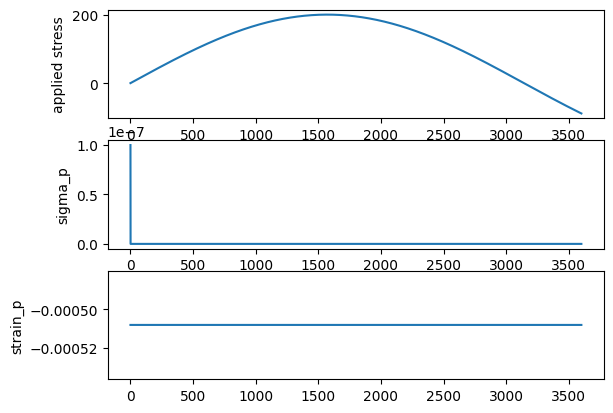

In [5]:
import matplotlib.pyplot as plt 

f, axs = plt.subplots(nrows=3,ncols=1)
axs[0].plot(sol_times, applied_stress)
axs[0].set_ylabel('applied stress')
axs[1].plot(sol_times, sigma_p)
axs[1].set_ylabel('sigma_p')
axs[2].plot(sol_times[1:], strain_p)
axs[2].set_ylabel('strain_p')

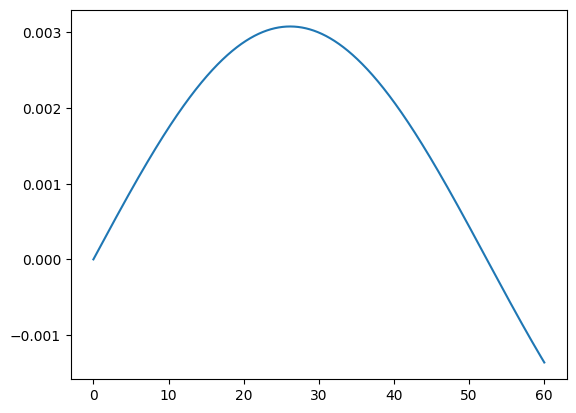

In [19]:
elastic_strain = applied_stress / mc_T.shear_mod
plt.plot(sol_times[1:].to('min'), elastic_strain[1:])